### Corn Disease Classification

# Importing Libraries and Modules

In [1]:
import numpy as np 
import pandas as pd
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt 

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
IMAGE_SIZE = (256,256)
BATCH_SIZE = 32

# Importing Images

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/kaggle/input/corn-or-maize-leaf-disease-dataset/data",
    shuffle=True,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

Found 4188 files belonging to 4 classes.


In [4]:
class_names = dataset.class_names
class_names

['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']

In [5]:
len(dataset)

131

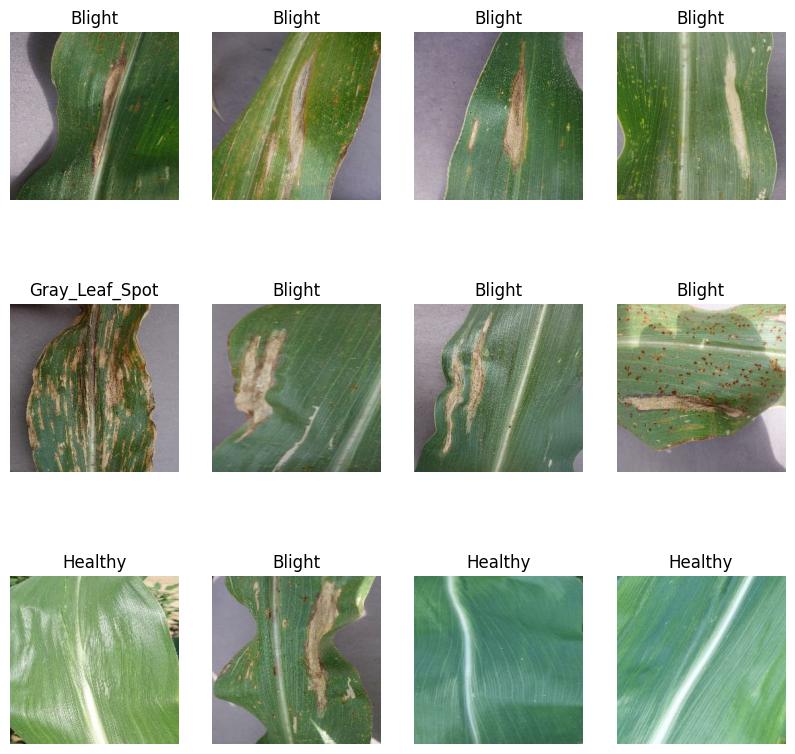

In [6]:
plt.figure(figsize=(10,10))
for image_batch , label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')

# Train-test Split

In [7]:
def get_dataset(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size,seed=8)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size) 
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds,val_ds,test_ds

In [8]:
train_ds,val_ds,test_ds = get_dataset(dataset)

In [9]:
print("Length of Training Dataset is",len(train_ds))
print("\nLength of Validation Dataset is",len(val_ds))
print("\nLength of Testing Dataset is",len(test_ds))

Length of Training Dataset is 104

Length of Validation Dataset is 13

Length of Testing Dataset is 14


In [10]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [11]:
resize_and_rescale = tf.keras.Sequential([
layers.experimental.preprocessing.Resizing(256,256),
layers.experimental.preprocessing.Rescaling(1.0/255)
])

# Model Building

In [12]:
n_classes = 4
input_shape = (BATCH_SIZE,256,256,3)
model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32,(3,3),activation ='relu',input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size = (3,3),activation ='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size = (3,3),activation ='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size = (3,3),activation ='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size = (3,3),activation ='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size = (3,3),activation ='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax'),
    
])
model.build(input_shape=input_shape)

In [13]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [14]:
model.compile(
optimizer='adam',
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
metrics=['accuracy']
)

# Model Fitting

In [15]:
history = model.fit(
train_ds,
epochs=60,
batch_size=BATCH_SIZE,
verbose=1,
validation_data=val_ds)

Epoch 1/60
104/104 [==============================] - 45s 139ms/step - loss: 0.9804 - accuracy: 0.5190 - val_loss: 0.8399 - val_accuracy: 0.5697
Epoch 2/60
104/104 [==============================] - 6s 56ms/step - loss: 0.8636 - accuracy: 0.5815 - val_loss: 0.7970 - val_accuracy: 0.6346
Epoch 3/60
104/104 [==============================] - 6s 56ms/step - loss: 0.5811 - accuracy: 0.7659 - val_loss: 0.4334 - val_accuracy: 0.8341
Epoch 4/60
104/104 [==============================] - 6s 56ms/step - loss: 0.4004 - accuracy: 0.8409 - val_loss: 0.3425 - val_accuracy: 0.8534
Epoch 5/60
104/104 [==============================] - 6s 56ms/step - loss: 0.3277 - accuracy: 0.8694 - val_loss: 0.3747 - val_accuracy: 0.8486
Epoch 6/60
104/104 [==============================] - 6s 56ms/step - loss: 0.3054 - accuracy: 0.8752 - val_loss: 0.2960 - val_accuracy: 0.8918
Epoch 7/60
104/104 [==============================] - 6s 56ms/step - loss: 0.2736 - accuracy: 0.8887 - val_loss: 0.2799 - val_accuracy: 0.86

In [16]:
scores = model.evaluate(test_ds)

14/14 [==============================] - 7s 25ms/step - loss: 0.1335 - accuracy: 0.9621


In [17]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

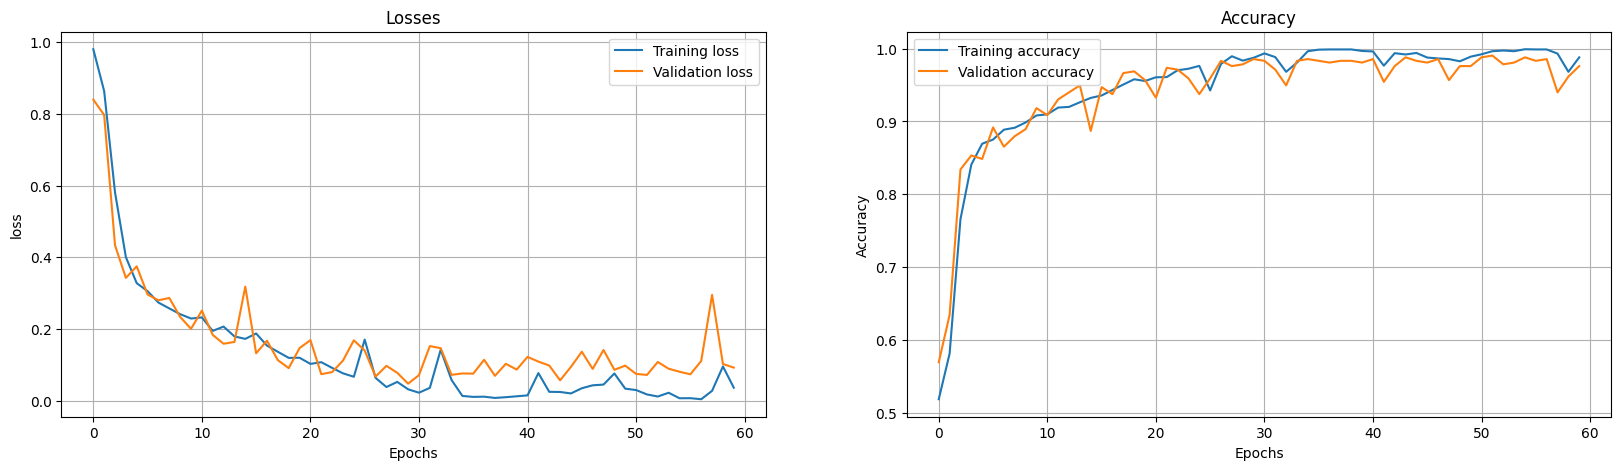

In [18]:
his_data = pd.DataFrame(history.history)
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
plt.plot(his_data.loss, label="Training loss")
plt.plot(his_data.val_loss, label="Validation loss")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.title("Losses")
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.plot(his_data.accuracy, label="Training accuracy")
plt.plot(his_data.val_accuracy, label="Validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy")
plt.grid()
plt.legend()

# Prediction

First Image to Predict :

Actual label: Common_Rust
1/1 [==============================] - 0s 172ms/step

Predicted label Common_Rust


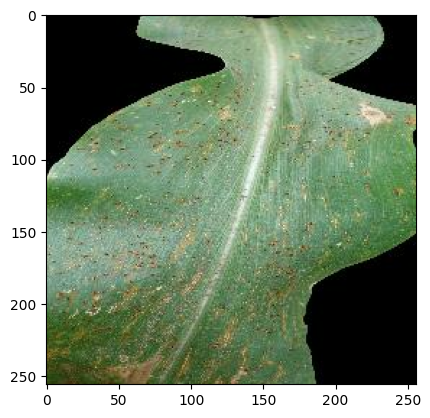

In [19]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    print("First Image to Predict :")
    plt.imshow(first_image)
    print("\nActual label:",class_names[first_label])
    batch_prediction = model.predict(images_batch) 
    print("\nPredicted label" ,class_names[np.argmax(batch_prediction[0])])

In [20]:
def predict(model,img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    predictions = model.predict (img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
#     confidence = round(np.max(predictions[0]),2)
    confidence = round(100*(np.max(predictions[0])),2)

    return predicted_class, confidence

1/1 [==============================] - 0s 21ms/step


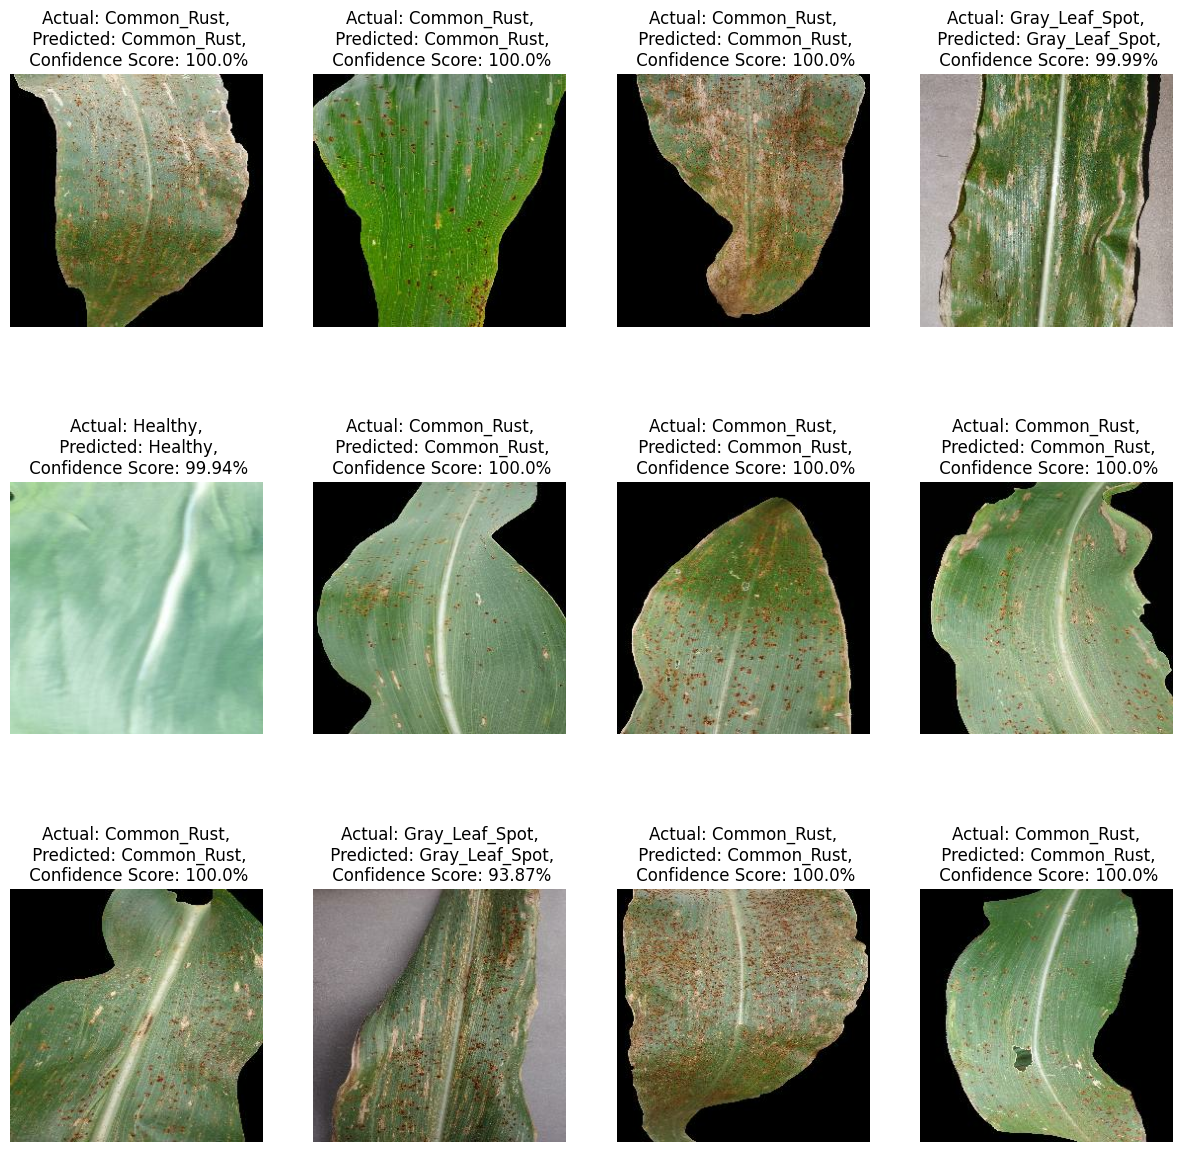

In [21]:
plt.figure(figsize=(15,15))
for images,labels in test_ds.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class , confidence = predict(model,images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class},\n Confidence Score: {confidence}%")
        plt.axis("off")

In [22]:
# model_version = 1
model.save('/kaggle/working/Disease_Classifier_Corn')

In [24]:
from IPython.display import FileLinks

# Assuming model_path is the directory you want to link to
model_path = "/kaggle/working/Disease_Classifier_Corn"

# Create download links for all files in the directory
display(FileLinks(model_path))



/kaggle/working/Disease_Classifier_Corn/
  keras_metadata.pb
  saved_model.pb
  fingerprint.pb
/kaggle/working/Disease_Classifier_Corn/variables/
  variables.index
  variables.data-00000-of-00001

In [25]:
import shutil


model_path = "/kaggle/working/Disease_Classifier_Corn"


shutil.make_archive("/kaggle/working/Disease_Classifier_Corn_archive", 'zip', model_path)


'/kaggle/working/Disease_Classifier_Corn_archive.zip'